In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FM2 - pre/post TVAC analysis

We consider two acquisitions. The first was taken during February 2024, prior to TVAC tests, the second was taken during June 2021, post TVAC.
The goal is to asses wether the light-output scintillator parameters changed significantly over this period, likely due to the tests.
Note that, since we did non acquire 176Lu during calibration, we have no way to assess if parameters changed significantly between calibration time and February 2024.

In [77]:
acquisition_fm2_path = {
    "pre-tvac": "data/fm2/20240221_hermes_fm2_176lu_LV0d5.fits",
    "post-tvac": "data/fm2/20240610_hermes_fm2_176lu_900s_part1_LV0d5.fits"
}

lu176_201 = 201.83
lu176_306 = 306.78
sources = [lu176_201, lu176_306]

## Temperatures

The temperatures between the two acquisition were similar, jsut above 20°C.

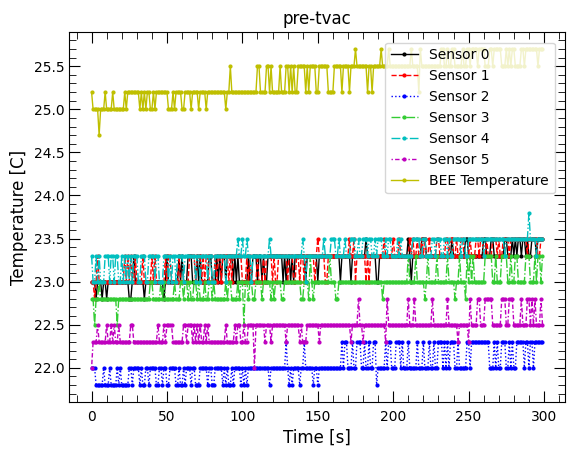

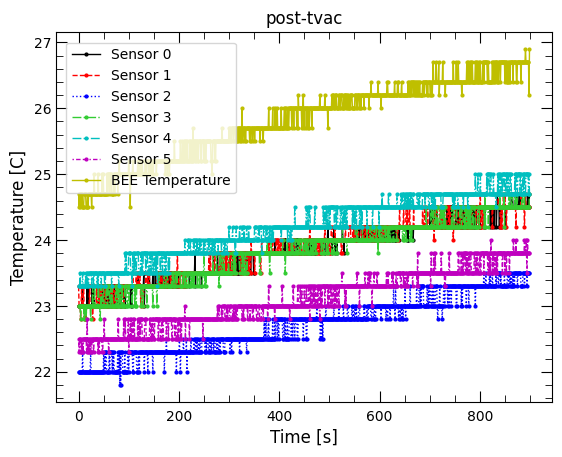

In [76]:
from astropy.io import fits

for label, filepath in acquisition_fm2_path.items():
    with fits.open(filepath) as f:
        hk_data = f[1].data
    
    temp_array = np.hstack((hk_data["FEETEMPP"], np.expand_dims(hk_data["BEETEMPP"], axis=1)))
    temp_df = pd.DataFrame(temp_array, columns=[f"Sensor {i}" for i in range(6)] + ["BEE Temperature"])
    temp_df.plot(ylabel="Temperature [C]", xlabel="Time [s]", marker="o", title=f"{label}", kind="line", ms=2)
    plt.show()

## Calibration

We load the 20°C standard calibration and cast it over both acquisitions.

In [24]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_LV0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return 
    
    def log(self, msg):
        pass

configuration = {
    "binning": 10
}
model="fm2"
sdd_standard_calibration = read_sdd_calibration_report(Path("data/fm2/standard_calib_fm2_20deg/report_cal.xlsx"))
slo_standard_calibration = read_lightout_report(Path("data/fm2/standard_calib_fm2_20deg/report_slo.xlsx")) 

def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_LV0d5(datafile)
    data, _ = preprocess(data, model=model, filter_spurious=True, filter_retrigger=20E-6)
    calibration = ImportedCalibration(
        model=model, 
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )
    return calibration(data), calibration

def histogram(data):
    bins = np.arange(50, 1500, .5)
    midpoints = (bins[:-1] + bins[1:]) / 2
    return np.histogram(data["ENERGY"], bins=bins)[0], midpoints


calibrate_standard_data = partial(_calibrate_data, model=model, sdd_calibration=sdd_standard_calibration, slo_calibration=slo_standard_calibration, configuration=configuration)

In [10]:
dataframes = {label: calibrate_standard_data(datafile) for label, datafile in acquisition_fm2_path.items()}

These are the spectra, along with the expected position of the lutetium gamma lines.

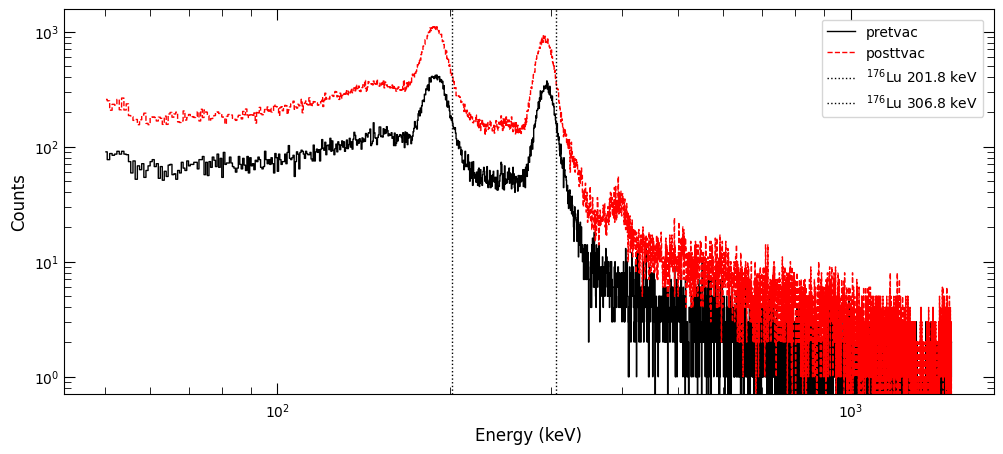

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
for label, (data, calibration) in dataframes.items():
    counts, midpoints = histogram(data) 
    ax.step(midpoints, counts, where="mid", label=label)
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.show()

## Calibration outliers

Centers of the peaks appears to be mostly consistent. Two side-lobes are present in the post-TVAC acquisition. The lutetium acquisition are not sufficient to fully calibrate the detector, hence to check variations in lightoutput by channel. However, we can still zoom in on the side-lobes and try to catch which channel contributed the most to them and is likely to have significantly changes its light-output.

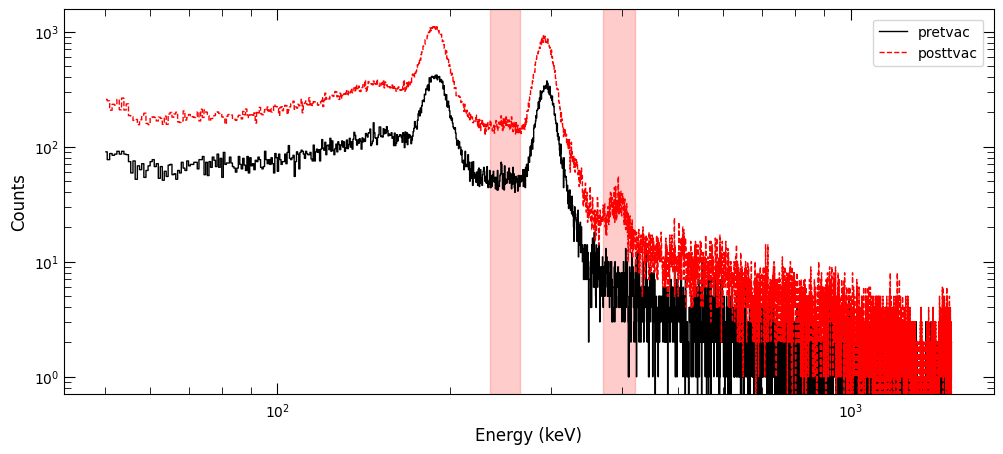

In [60]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
for label, (data, calibration) in dataframes.items():
    counts, midpoints = histogram(data) 
    ax.step(midpoints, counts, where="mid", label=label)
plt.axvspan(370, 420, alpha=0.2, color="red")
plt.axvspan(235, 265, alpha=0.2, color="red")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.show()

We select a data slice spanning both side-lobes, as highlighted with the red regions above.

In [61]:
df, calibration = dataframes["posttvac"]
mask = (df["EVTYPE"] == "S") & ((370 < df["ENERGY"]) & (df["ENERGY"] < 420) |  (235 < df["ENERGY"]) & (df["ENERGY"] < 275)) 
df[mask].sort_values("ENERGY")

,ENERGY,TIME,ELECTRONS,EVTYPE,CHN,QUADID
26868,235.000966,7.703384e+07,6716.994141,S,14,A
51200,235.002165,7.703393e+07,7463.557617,S,23,C
11920,235.002622,7.703378e+07,7108.791504,S,16,D
99921,235.002739,7.703413e+07,5994.156738,S,3,C
125350,235.003931,7.703423e+07,6221.107910,S,7,B
...,...,...,...,...,...,...
72715,419.903307,7.703402e+07,8951.007812,S,6,C
202637,419.917606,7.703455e+07,11592.962891,S,31,B
52085,419.958981,7.703394e+07,12338.862305,S,6,A
57860,419.978021,7.703396e+07,12940.984375,S,30,B


Plotting by-scintillator counts over the sidelobes regions it is apparent that the channel which contributed the most was B17.

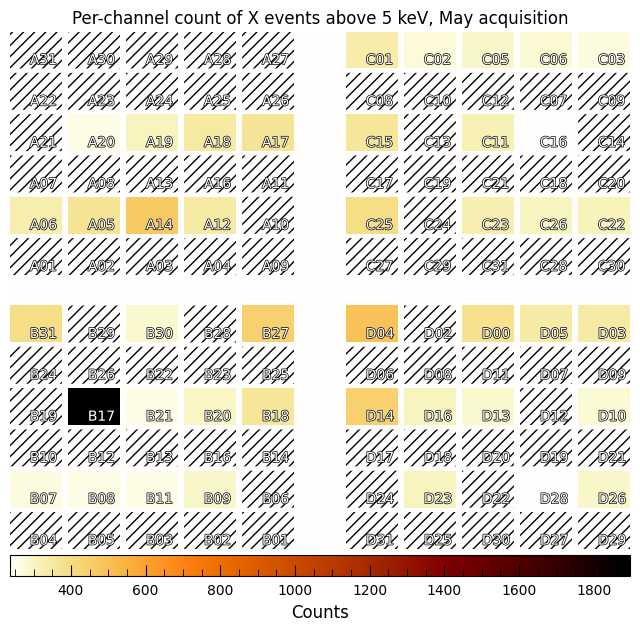

In [55]:
from source.eventlist import perchannel_counts
from source.plot import mapcounts

fig, ax = mapcounts(perchannel_counts(df[mask], calibration.channels), calibration.detector.map, title="Per-channel count of X events above 5 keV, May acquisition")

The channel B17 appears to have increased its light-output by $\sim 32\%$.

## Non-linearity correction

Finally, we try to correct the non-linearity, using the 20°C mixed-splice model. The correction is on point for the 306.8 keV line and subdued by a few percent for the 201.8 keV line. Both lines lies in the spline-fitted domain.

In [38]:
from astropy.io import fits
from scipy.interpolate import interp1d

with fits.open("data/hermes_mixedsplice.fits") as content:
    corr_factor = content[1].data
    f1 = interp1d(corr_factor["ENERGY"], corr_factor["CORRFACTOR"])


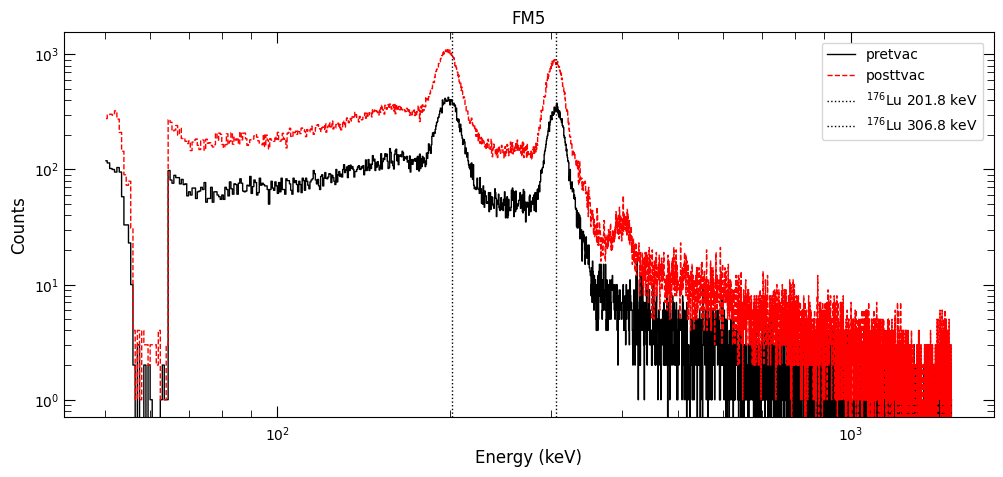

In [40]:
def get_mask(df):
    return (df["ENERGY"] > 10) & (df["EVTYPE"] == "S") & (df["ENERGY"] < 1999.90)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for label, (data, calibration) in dataframes.items():
    data = {"ENERGY": data[get_mask(data)]["ENERGY"] / f1(data[get_mask(data)]["ENERGY"])}
    counts, midpoints = histogram(data)
    ax.step(midpoints, counts, where="mid", label=f"{label}")
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("FM5")
plt.show()